# Prerequisites

Please make sure to follow these steps to start using TimeGEN: 

* Register for a valid Azure account with subscription 
* Make sure you have access to [Azure AI Studio](https://learn.microsoft.com/en-us/azure/ai-studio/what-is-ai-studio?tabs=home)
* Create a project and resource group
* Select `TimeGEN-1`.

    > Notice that some models may not be available in all the regions in Azure AI and Azure Machine Learning. On those cases, you can create a workspace or project in the region where the models are available and then consume it with a connection from a different one. To learn more about using connections see [Consume models with connections](https://learn.microsoft.com/en-us/azure/ai-studio/how-to/deployments-connections)

* Deploy with "Pay-as-you-go"

Once deployed successfully, you should be assigned for an API endpoint and a security key for inference.

To complete this tutorial, you will need to:

* Install `nixtla` and `pandas`:

    ```bash
    pip install nixtla pandas
    ```

# Forecasting Demand

In this tutorial, we show how to use TimeGEN on an intermittent series where we have many values at zero. Here, we use a subset of the M5 dataset that tracks the demand for food items in a Californian store. The dataset also includes exogenous variables like the sell price and the type of event occuring at a particular day.

TimeGEN achieves the best performance at a MAE of 0.49, which represents a **14% improvement** over the best statistical model specifically built to handle intermittent time series data.

To complete this tutorial, you will need to:

* Install `nixtla`, `pandas`, `numpy`, `utilsforecast`, `statsforecast`:

    ```bash
    pip install nixtla pandas numpy utilsforecast statsforecast
    ```

## Initial setup

We start off by importing the required packages for this tutorial and create an instace of `NixtlaClient`.

In [ ]:
import time
import pandas as pd
import numpy as np

from nixtla import NixtlaClient

from utilsforecast.losses import mae
from utilsforecast.evaluation import evaluate

In [ ]:
nixtla_client = NixtlaClient(
    base_url="you azure ai endpoint",
    api_key="your api_key",
)

We now read the dataset and plot it.

In [ ]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/m5_sales_exog_small.csv"
)
df["ds"] = pd.to_datetime(df["ds"])

df.head()

,unique_id,ds,y,sell_price,event_type_Cultural,event_type_National,event_type_Religious,event_type_Sporting
0,FOODS_1_001,2011-01-29,3,2.0,0,0,0,0
1,FOODS_1_001,2011-01-30,0,2.0,0,0,0,0
2,FOODS_1_001,2011-01-31,0,2.0,0,0,0,0
3,FOODS_1_001,2011-02-01,1,2.0,0,0,0,0
4,FOODS_1_001,2011-02-02,4,2.0,0,0,0,0


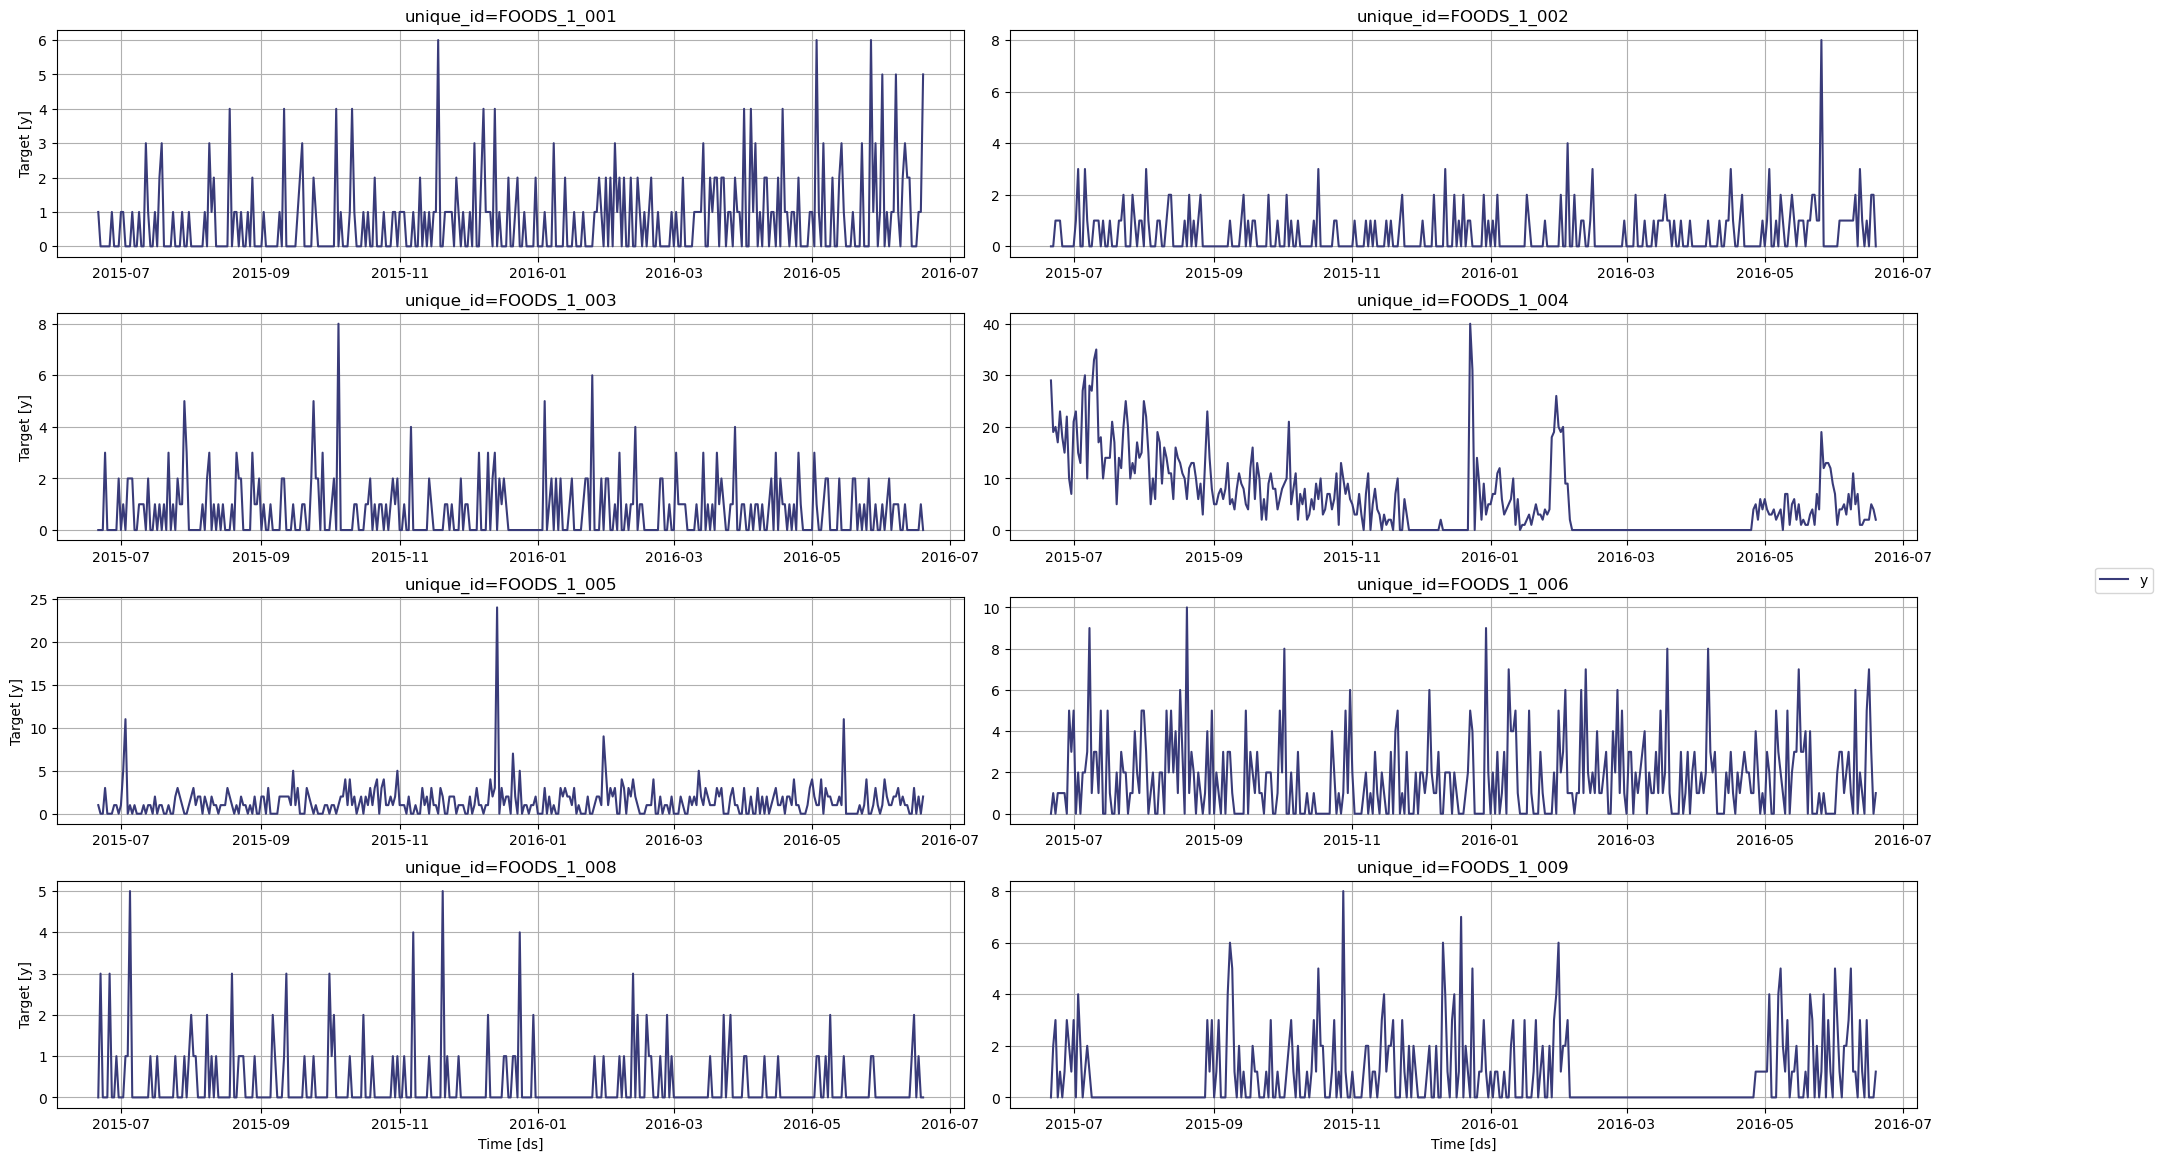

In [ ]:
nixtla_client.plot(
    df,
    max_insample_length=365,
)

In the figure above, we can see the intermittent nature of this dataset, with many periods with zero demand.

Now, let's use TimeGEN to forecast the demand of each product.

## Bounded forecasts

To avoid getting negative predictions coming from the model, we use a log transformation on the data. That way, the model will be forced to predict only positive values.

Note that due to the presence of zeros in our dataset, we add one to all points before taking the log.

In [ ]:
df_transformed = df.copy()

df_transformed["y"] = np.log(df_transformed["y"] + 1)

df_transformed.head()

,unique_id,ds,y,sell_price,event_type_Cultural,event_type_National,event_type_Religious,event_type_Sporting
0,FOODS_1_001,2011-01-29,1.386294,2.0,0,0,0,0
1,FOODS_1_001,2011-01-30,0.000000,2.0,0,0,0,0
2,FOODS_1_001,2011-01-31,0.000000,2.0,0,0,0,0
3,FOODS_1_001,2011-02-01,0.693147,2.0,0,0,0,0
4,FOODS_1_001,2011-02-02,1.609438,2.0,0,0,0,0


Now, let's keep the last 28 time steps for the test set and use the rest as input to the model.

In [ ]:
test_df = df_transformed.groupby("unique_id").tail(28)

input_df = df_transformed.drop(test_df.index).reset_index(drop=True)

## Forecasting with TimeGEN

In [ ]:
start = time.time()

fcst_df = nixtla_client.forecast(
    df=input_df,
    h=28,
    level=[80],  # Generate a 80% confidence interval
    finetune_steps=10,  # Specify the number of steps for fine-tuning
    finetune_loss="mae",  # Use the MAE as the loss function for fine-tuning
    time_col="ds",
    target_col="y",
    id_col="unique_id",
)

end = time.time()

TimeGEN_duration = end - start

print(f"Time (TimeGEN): {TimeGEN_duration}")

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Time (TimeGEN): 3.240954637527466


Great! TimeGEN was done in **5.8 seconds** and we now have predictions. However, those predictions are transformed, so we need to inverse the transformation to get back to the orignal scale. Therefore, we take the exponential and subtract one from each data point.

In [ ]:
cols = [col for col in fcst_df.columns if col not in ["ds", "unique_id"]]

for col in cols:
    fcst_df[col] = np.exp(fcst_df[col]) - 1

fcst_df.head()

,unique_id,ds,TimeGPT,TimeGPT-lo-80,TimeGPT-hi-80
0,FOODS_1_001,2016-05-23,0.286728,-0.267165,1.259265
1,FOODS_1_001,2016-05-24,0.322617,-0.240010,1.301760
2,FOODS_1_001,2016-05-25,0.288585,-0.361659,1.601199
3,FOODS_1_001,2016-05-26,0.295928,-0.145092,0.964454
4,FOODS_1_001,2016-05-27,0.314914,-0.167121,1.075930


## Evaluation

Before measuring the performance metric, let's plot the predictions against the actual values.

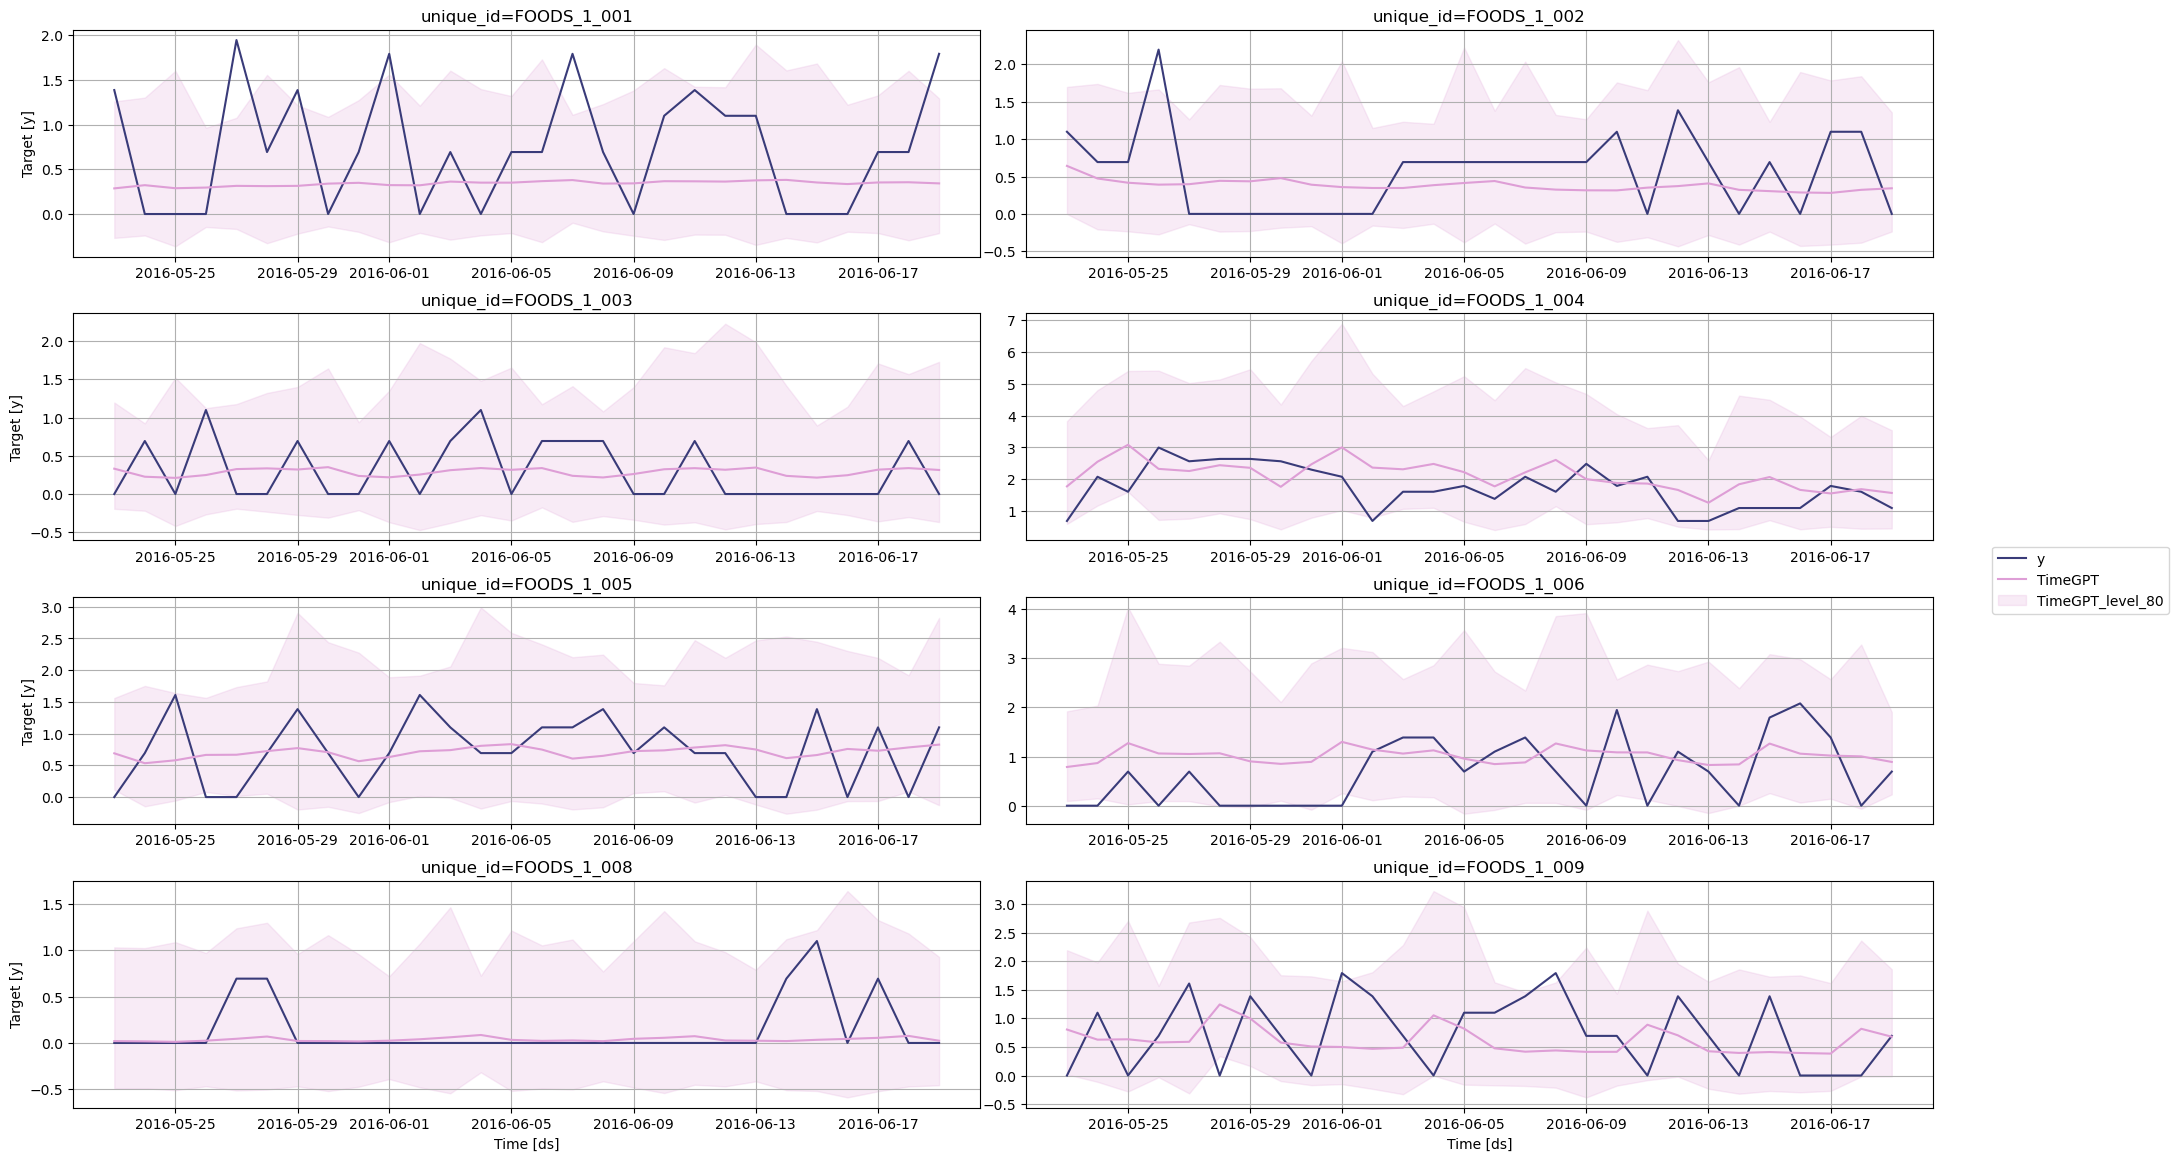

In [ ]:
nixtla_client.plot(
    test_df, fcst_df, models=["TimeGPT"], level=[80], time_col="ds", target_col="y"
)

Finally, we can measure the mean absolute error (MAE) of the model.

In [ ]:
fcst_df["ds"] = pd.to_datetime(fcst_df["ds"])

test_df = pd.merge(test_df, fcst_df, "left", ["unique_id", "ds"])

In [ ]:
evaluation = evaluate(
    test_df, metrics=[mae], models=["TimeGPT"], target_col="y", id_col="unique_id"
)

average_metrics = evaluation.groupby("metric")["TimeGPT"].mean()
average_metrics

metric
mae    0.492926
Name: TimeGPT, dtype: float64

## Forecasting with statistical models

The library `statsforecast` by Nixtla provides a suite of statistical models specifically built for intermittent forecasting, such as Croston, IMAPA and TSB. Let's use these models and see how they perform against TimeGEN.

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import CrostonClassic, CrostonOptimized, IMAPA, TSB

/home/ubuntu/miniconda/envs/nixtlats/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Here, we use four models: two versions of Croston, IMAPA and TSB.

In [ ]:
models = [CrostonClassic(), CrostonOptimized(), IMAPA(), TSB(0.1, 0.1)]

sf = StatsForecast(models=models, freq="D", n_jobs=-1)

Then, we can fit the models on our data.

In [ ]:
start = time.time()

sf.fit(df=input_df)

sf_preds = sf.predict(h=28)

end = time.time()

sf_duration = end - start

print(f"Statistical models took :{sf_duration}s")

Statistical models took :8.325005531311035s


Here, fitting and predicting with four statistical models took 5.2 seconds, while TimeGEN took 5.8 seconds, so TimeGEN was only 0.6 seconds slower.

Again, we need to inverse the transformation. Remember that the training data was previously transformed using the log function.

In [ ]:
cols = [col for col in sf_preds.columns if col not in ["ds", "unique_id"]]

for col in cols:
    sf_preds[col] = np.exp(sf_preds[col]) - 1

sf_preds.head()

,ds,CrostonClassic,CrostonOptimized,IMAPA,TSB
unique_id,,,,,
FOODS_1_001,2016-05-23,0.599093,0.599093,0.445779,0.396258
FOODS_1_001,2016-05-24,0.599093,0.599093,0.445779,0.396258
FOODS_1_001,2016-05-25,0.599093,0.599093,0.445779,0.396258
FOODS_1_001,2016-05-26,0.599093,0.599093,0.445779,0.396258
FOODS_1_001,2016-05-27,0.599093,0.599093,0.445779,0.396258


## Evaluation

Now, let's combine the predictions from all methods and see which performs best.

In [ ]:
test_df = pd.merge(test_df, sf_preds, "left", ["unique_id", "ds"])
test_df.head()

,unique_id,ds,y,sell_price,event_type_Cultural,event_type_National,event_type_Religious,event_type_Sporting,TimeGPT,TimeGPT-lo-80,TimeGPT-hi-80,CrostonClassic,CrostonOptimized,IMAPA,TSB
0,FOODS_1_001,2016-05-23,1.386294,2.24,0,0,0,0,0.286728,-0.267165,1.259265,0.599093,0.599093,0.445779,0.396258
1,FOODS_1_001,2016-05-24,0.000000,2.24,0,0,0,0,0.322617,-0.240010,1.301760,0.599093,0.599093,0.445779,0.396258
2,FOODS_1_001,2016-05-25,0.000000,2.24,0,0,0,0,0.288585,-0.361659,1.601199,0.599093,0.599093,0.445779,0.396258
3,FOODS_1_001,2016-05-26,0.000000,2.24,0,0,0,0,0.295928,-0.145092,0.964454,0.599093,0.599093,0.445779,0.396258
4,FOODS_1_001,2016-05-27,1.945910,2.24,0,0,0,0,0.314914,-0.167121,1.075930,0.599093,0.599093,0.445779,0.396258


In [ ]:
evaluation = evaluate(
    test_df,
    metrics=[mae],
    models=["TimeGPT", "CrostonClassic", "CrostonOptimized", "IMAPA", "TSB"],
    target_col="y",
    id_col="unique_id",
)

average_metrics = evaluation.groupby("metric")[
    ["TimeGPT", "CrostonClassic", "CrostonOptimized", "IMAPA", "TSB"]
].mean()
average_metrics

,TimeGPT,CrostonClassic,CrostonOptimized,IMAPA,TSB
metric,,,,,
mae,0.492926,0.564563,0.580922,0.571943,0.567178


In the table above, we can see that TimeGEN achieves the lowest MAE, achieving a 12.8% improvement over the best performing statistical model.

Now, this was done without using any of the available exogenous features. While the statsitical models do not support them, let's try including them in TimeGEN.

## Forecasting with exogenous variables using TimeGEN

To forecast with exogenous variables, we need to specify their future values over the forecast horizon. Therefore, let's simply take the types of events, as those dates are known in advance. 

In [ ]:
futr_exog_df = test_df.drop(
    [
        "TimeGPT",
        "CrostonClassic",
        "CrostonOptimized",
        "IMAPA",
        "TSB",
        "y",
        "TimeGPT-lo-80",
        "TimeGPT-hi-80",
        "sell_price",
    ],
    axis=1,
)
futr_exog_df.head()

,unique_id,ds,event_type_Cultural,event_type_National,event_type_Religious,event_type_Sporting
0,FOODS_1_001,2016-05-23,0,0,0,0
1,FOODS_1_001,2016-05-24,0,0,0,0
2,FOODS_1_001,2016-05-25,0,0,0,0
3,FOODS_1_001,2016-05-26,0,0,0,0
4,FOODS_1_001,2016-05-27,0,0,0,0


Then, we simply call the `forecast` method and pass the `futr_exog_df` in the `X_df` parameter.

In [ ]:
start = time.time()

fcst_df = nixtla_client.forecast(
    df=input_df,
    X_df=futr_exog_df,
    h=28,
    level=[80],  # Generate a 80% confidence interval
    finetune_steps=10,  # Specify the number of steps for fine-tuning
    finetune_loss="mae",  # Use the MAE as the loss function for fine-tuning
    time_col="ds",
    target_col="y",
    id_col="unique_id",
)

end = time.time()

TimeGEN_duration = end - start

print(f"Time (TimeGEN): {TimeGEN_duration}")

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Using the following exogenous variables: event_type_Cultural, event_type_National, event_type_Religious, event_type_Sporting
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Time (TimeGEN): 3.8751087188720703


Great! Remember that the predictions are transformed, so we have to inverse the transformation again.

In [ ]:
fcst_df.rename(
    columns={
        "TimeGPT": "TimeGPT_ex",
    },
    inplace=True,
)

cols = [col for col in fcst_df.columns if col not in ["ds", "unique_id"]]

for col in cols:
    fcst_df[col] = np.exp(fcst_df[col]) - 1

fcst_df.head()

,unique_id,ds,TimeGPT_ex,TimeGPT-lo-80,TimeGPT-hi-80
0,FOODS_1_001,2016-05-23,0.281552,-0.270113,1.250178
1,FOODS_1_001,2016-05-24,0.315217,-0.244262,1.288882
2,FOODS_1_001,2016-05-25,0.287086,-0.362402,1.598173
3,FOODS_1_001,2016-05-26,0.295806,-0.145172,0.964270
4,FOODS_1_001,2016-05-27,0.314827,-0.167176,1.075793


## Evaluation

Finally, let's evaluate the performance of TimeGEN with exogenous features.

In [ ]:
test_df["TimeGPT_ex"] = fcst_df["TimeGPT_ex"].values
test_df.head()

,unique_id,ds,y,sell_price,event_type_Cultural,event_type_National,event_type_Religious,event_type_Sporting,TimeGPT,TimeGPT-lo-80,TimeGPT-hi-80,CrostonClassic,CrostonOptimized,IMAPA,TSB,TimeGPT_ex
0,FOODS_1_001,2016-05-23,1.386294,2.24,0,0,0,0,0.286728,-0.267165,1.259265,0.599093,0.599093,0.445779,0.396258,0.281552
1,FOODS_1_001,2016-05-24,0.000000,2.24,0,0,0,0,0.322617,-0.240010,1.301760,0.599093,0.599093,0.445779,0.396258,0.315217
2,FOODS_1_001,2016-05-25,0.000000,2.24,0,0,0,0,0.288585,-0.361659,1.601199,0.599093,0.599093,0.445779,0.396258,0.287086
3,FOODS_1_001,2016-05-26,0.000000,2.24,0,0,0,0,0.295928,-0.145092,0.964454,0.599093,0.599093,0.445779,0.396258,0.295806
4,FOODS_1_001,2016-05-27,1.945910,2.24,0,0,0,0,0.314914,-0.167121,1.075930,0.599093,0.599093,0.445779,0.396258,0.314827


In [ ]:
evaluation = evaluate(
    test_df,
    metrics=[mae],
    models=[
        "TimeGPT",
        "CrostonClassic",
        "CrostonOptimized",
        "IMAPA",
        "TSB",
        "TimeGPT_ex",
    ],
    target_col="y",
    id_col="unique_id",
)

average_metrics = evaluation.groupby("metric")[
    ["TimeGPT", "CrostonClassic", "CrostonOptimized", "IMAPA", "TSB", "TimeGPT_ex"]
].mean()
average_metrics

,TimeGPT,CrostonClassic,CrostonOptimized,IMAPA,TSB,TimeGPT_ex
metric,,,,,,
mae,0.492926,0.564563,0.580922,0.571943,0.567178,0.485695


From the table above, we can see that using exogenous features improved the performance of TimeGEN. Now, it represents a 14% improvement over the best statistical model. 

Using TimeGEN with exogenous features took 6.8 seconds. This is 1.6 seconds slower than statitstical models, but it resulted in much better predictions.